# Import libraries



In [1]:
import os
import time
import clip
import torch
import pickle
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from sklearn import preprocessing
%matplotlib inline
from matplotlib import pyplot as plt
from DICTOL_python.dictol.utils import randperm
from DICTOL_python.dictol.utils import label_to_range
from DICTOL_python.dictol.utils import get_block_col
from DICTOL_python.dictol.utils import normc
from DICTOL_python.dictol import SRC, DLSI

/home/dfc/projects/classes/bdivs/lab6/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load CroppedYale database and Compute feature vectors

In [2]:
# Indicate the desired device: 'cpu' or 'cuda'
device = 'cuda'
device = torch.device(device if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
class RP(torch.nn.Module):
    """Implementation of random image descriptor: random projection class"""
    
    def __init__(self, dim_in, dim_out, resize_shape, device='cpu'):
        """
        Constructor.

        Args:
            dim_in (int): input dimension of images. Note that we will flatten images of shape (W, H, 3) to (W * H * 3)
            dim_out (int): output dimension of image features.
            resize_shape (tuple): resize the images to this (W, H) shape.
            device (str, optional): use either 'cpu' or 'cuda' (gpu). Defaults to 'cpu'.
        """
        super(RP, self).__init__()
        
        # Save hyperparameters as attributes
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.preprocess = PreprocessRP(resize_shape, device)  # Define preprocessing
        
        # Create normalized random Gaussian matrix with shape (dim_in, dim_out)
        self.proj_mat = torch.tensor(
            np.sqrt(dim_out) * np.random.randn(dim_in, dim_out)  # np.sqrt(dim_out) normalizes every column to 1
        ).float().unsqueeze(0).to(device)

    def forward(self, X):
        """
        Compute random projections over X, where every row is data sample.

        Args:
            X (torch.tensor): input images with shape (B, 1, dim_in)

        Returns:
            torch.tensor: random descriptor with shape (B, 1, dim_out)
        """
        rp_feat = X @ self.proj_mat
        return rp_feat


class PreprocessRP(torch.nn.Module):
    """Preprocess images: convert to torch tensor, resize, normalize, and flatten image (keeping batch dimension)."""
    
    def __init__(self, resize_shape, device='cpu'):
        """
        Constructor

        Args:
            resize_shape (tuple): resize the images to this (W, H) shape.
            device (str, optional): _description_. Defaults to 'cpu'.
        """
        super(PreprocessRP, self).__init__()
        self.resize_shape = resize_shape
        self.device = device
    
    def forward(self, X):
        """
        Apply preprocessing for the RP class. Preprocessing consists in converting images to torch tensor, resizing, normalizing, and flattening.

        Args:
            X (PIL.Image): image to be preprocessed for random projection.

        Returns:
            torch.Tensor: preprocessed image.
        """
        X = torch.tensor(np.array(X)).unsqueeze(0).to(self.device).float()  # Define image as torch tensor of shape (W_prev, H_prev, C)
        X = X.permute(0, 3, 1, 2)  # Reshape to (C, W_prev, H_prev)
        X = torch.nn.functional.interpolate(
            X, size=self.resize_shape, mode='bicubic', align_corners=False  # Interpolate to resize to new shape (C, W_new, H_new)
        )
        X = X / 255 - 0.5
        return X.reshape(1, -1)  # Flatten to obtain shape (1, C * W_new * H_new), which is equal to (1, dim_in) for the RP class

In [4]:
# Select image feature descriptor and parameters
feat_desc = {
  'type': 'clip',         # Type of feature descriptor: clip or random
  'im_size': (192, 168),  # Image size (width, height) to be processed. It is resized if necessary.
  'dim_feat': 504,        # Dimensionality of feature descriptors for RP class
  'model': [],            # Feature descriptor module
  'preprocess': []        # Image preprocessing
}

# Initialize image feature descriptor: CLIP
if feat_desc['type'] == 'clip':
  
  # Load CLIP
  model, preprocess = clip.load("ViT-B/16", device=device)
  
  # Set model in evaluation mode and move to device (CPU or GPU)
  model.eval()
  
  # Define model and preprocessing
  feat_desc['model'] = model.encode_image
  feat_desc['preprocess'] = preprocess

# Initialize image feature descriptor: Random
elif feat_desc['type'] == 'random':
  
  # Define image's width and height
  imsize_wh = np.array(feat_desc['im_size']).transpose()
  
  # Load Random Projection class
  rp = RP(
    dim_in=np.prod(imsize_wh) * 3,  # dim_in = W * H * 3
    dim_out=feat_desc['dim_feat'],
    resize_shape=tuple(imsize_wh),  # Images are large and need to be resized
    device=device
  ).to(device)
  
  # Define model and preprocessing
  feat_desc['model'] = rp
  feat_desc['preprocess'] = rp.preprocess

# Else: Error
else:
  print("Unkonw image feature descriptor type.")
  exit()

In [5]:
class DataGenerator(torch.utils.data.Dataset):
    """Define a data generator to load images in a batch, and apply preprocessing to them"""
    
    def __init__(self, path, files=None, preprocess=None):
        """
        Constructor.

        Args:
            path (str): path to directory with images.
            files (list, optional): list of image filenames. Defaults to None.
            preprocess (optional): preprocessing module. Defaults to None.
        """
        super(DataGenerator).__init__()
        self.path = path
        self.files = sorted(os.listdir(path)) if files is None else files
        self.files = [f for f in self.files if f.endswith(".pgm") and not f.endswith("_Ambient.pgm")]
        self.preprocess = preprocess
        
    def __len__(self):
        """
        Length of the data generator, i.e., number of images to load.

        Returns:
            int: length of the data generator.
        """
        return len(self.files)
        
    def __getitem__(self, index):
        """
        Load image.

        Args:
            index (int): image index relative to the list of images (self.files).

        Returns:
            torch.tensor: image tensor with shape (W, H, C).
        """
        
        # Load image
        filepath = os.path.join(self.path, self.files[index])
        image = Image.open(filepath).convert("RGB")
        
        # Apply preprocessing
        if self.preprocess is not None:
            image = self.preprocess(image)
        return image

In [6]:
def compute_image_features(dataset_path, pickle_path, feat_desc, device='cpu', batch_size=256, num_workers=8):
    """
    Computatation of image features.

    Args:
        dataset_path (str): path of dataset.
        pickle_path (str): path to save descriptors as pickle files.
        feat_desc (dict): dictionary with the image feature descriptor to be used and parameters.
        device (str, optional): either 'cpu' or 'cuda'.
        batch_size (int, optional): size of the batch of images processes simultaneously. Defaults to 256.
        num_workers (int, optional): number of workers (cpu cores) that will load data simutaneously. Defaults to 8.

    Returns:
        list: list of feature embeddings.
        list: list of ground-truths (labels).
    """
    feat_list = []
    label_list = []

    # If previous image features where saved as pickle files, load them
    if os.path.isfile(pickle_path):
      
      # Load descriptors
      with open(pickle_path, 'rb') as file:
        feat_list, label_list = pickle.load(file)
      print(f"Loaded {len(feat_list)} descriptors from: {pickle_path}")
      
    else:
      
      # Select directory
      i = 0
      directories = sorted(os.listdir(dataset_path))
      for directory in tqdm(directories):
        i += 1
        path = os.path.join(dataset_path, directory)
        
        # Generate images
        dataset = DataGenerator(path, preprocess=feat_desc['preprocess'])
        dataloader = torch.utils.data.DataLoader(dataset, batch_size, num_workers)
        for batch in dataloader:
          batch = batch.to(device)
          
          # Calculate feature vector from images
          with torch.no_grad():
            image_features = feat_desc['model'](batch).float()
            
          # Post-processing (for CLIP)
          if feat_desc['type'] == 'clip':
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
          # Save feature vectors in list
          for image_feature in image_features.cpu().detach().numpy():
            feat_list.append(image_feature)
          
          # Estimate labels from folder names
          for filename in os.listdir(path):
            if filename.endswith(".pgm") and not filename.endswith("_Ambient.pgm"):
              full_path = os.path.dirname(os.path.abspath(os.path.join(path, filename)))
              label = os.path.normpath(full_path).split(os.path.sep)[-1]
              label_list.append(label)
          
      # Save descriptors as pickle files
      with open(pickle_path, 'wb') as file:
        pickle.dump([feat_list, label_list], file)
      print(f"Generated {len(feat_list)} descriptors, saved in: {pickle_path}")
    
    # Return feature descriptors and labels
    return feat_list, label_list

# Directory to save descriptors as pickle files
pickle_path = f"descriptors_{feat_desc['type']}.pkl"
  
# Compute image descriptors
dataset_path = os.path.abspath('CroppedYale')
feat_list, label_list = compute_image_features(dataset_path, pickle_path, feat_desc, device=device)

Loaded 2414 descriptors from: descriptors_clip.pkl


In [7]:
def load_CroppedYale_train_test(feat_list, label_list, N_train_c):
    """
    Main function to load training and test samples from CroppedYale database.

    Args:
        feat_list (list): list of feature descriptors
        label_list (list): list of ground-truths (labels)
        N_train_c (int): number of training images per class to learn/build dictionary.

    Returns:
        numpy.array: train split of data.
    """
    Y = np.asarray(feat_list).squeeze().transpose()
    
    # Label enconding
    le = preprocessing.LabelEncoder()
    le.fit(label_list)
    label_int = le.transform(label_list) + 1  # Function label_to_range() requires that labels start by 1 (not 0)

    # Size of feature vectors computed from images
    d = Y.shape[0]
    
    # Set labels as a range
    Y_range = np.array(label_to_range(label_int))

    # Size of train-test split
    C = Y_range.size - 1
    N_total = Y_range[-1]
    N_train = C * N_train_c
    N_test = N_total - N_train
    if (N_test <= 0):
      print(f'Number of samples: {N_total}')
      print(f'Number of training samples: {N_train}')
      print(f'Number of training samples: {N_test}')
      raise Exception("Too many samples in the training subset. There in not enough for testing. Reduce the value of variable N_train_c.")

    # Initialize train and test splits
    Y_train = np.zeros((d, N_train))
    Y_test = np.zeros((d, N_test))
    label_train = [0] * N_train
    label_test = [0] * N_test
    cur_train = 0
    cur_test = 0
    
    # For each class
    for c in range(C):
        
        # Get data
        Yc = get_block_col(Y, c, Y_range)
        N_total_c = Yc.shape[1]
        N_test_c = N_total_c - N_train_c
        if (N_test_c <= 0):
          print(f'Number of samples for class {le.inverse_transform(c)}: {N_total_c}')
          print(f'Number of training samples for class {le.inverse_transform(c)}: {N_train_c}')
          print(f'Number of testing samples for class {le.inverse_transform(c)}: {N_test_c}')
          str_0 = f"Too many samples in the training subset for the class {le.inverse_transform(c)}.  There in not enough for testing. Reduce the value of variable N_train_c."
          raise Exception(str_0)
      
        # Assign labels to train and test splits
        label_train[cur_train: cur_train + N_train_c] = [c + 1] * N_train_c
        label_test[cur_test:cur_test + N_test_c] = [c + 1] * N_test_c

        # Assign data to train and test splits
        ids = randperm(N_total_c)
        Y_train[:, cur_train: cur_train + N_train_c] = Yc[:, np.sort(ids[:N_train_c])]
        Y_test[:, cur_test: cur_test + N_test_c] = Yc[:, np.sort(ids[N_train_c:])]

        # Update counter
        cur_train += N_train_c
        cur_test += N_test_c

    # Normalize
    Y_train = normc(Y_train)
    Y_test = normc(Y_test)
    
    # Return splits
    return Y_train, label_train, Y_test, label_test, le

In [8]:
# Training images per class to build dictionary. Total training samples: N_train x Num classes
N_train = 32

# Apply train-test split
start = time.time()
Y_train, label_train, Y_test, label_test, le = load_CroppedYale_train_test(feat_list, label_list, N_train)
end = time.time()

# Print info
print(f'Elapse time for loading dataset and feature computation (s): {end - start}')
print(f'Num training images: {Y_train.shape[1]}')
print(f'Num test images: {Y_test.shape[1]}')
print(f'Class ids: {set(label_train)}')

Elapse time for loading dataset and feature computation (s): 0.009946823120117188
Num training images: 1216
Num test images: 1198
Class ids: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}


## (Optional) Visualize feature vectors in a 2 subspace with t-sne

[Text(0.5, 1.0, 'Data T-SNE projection')]

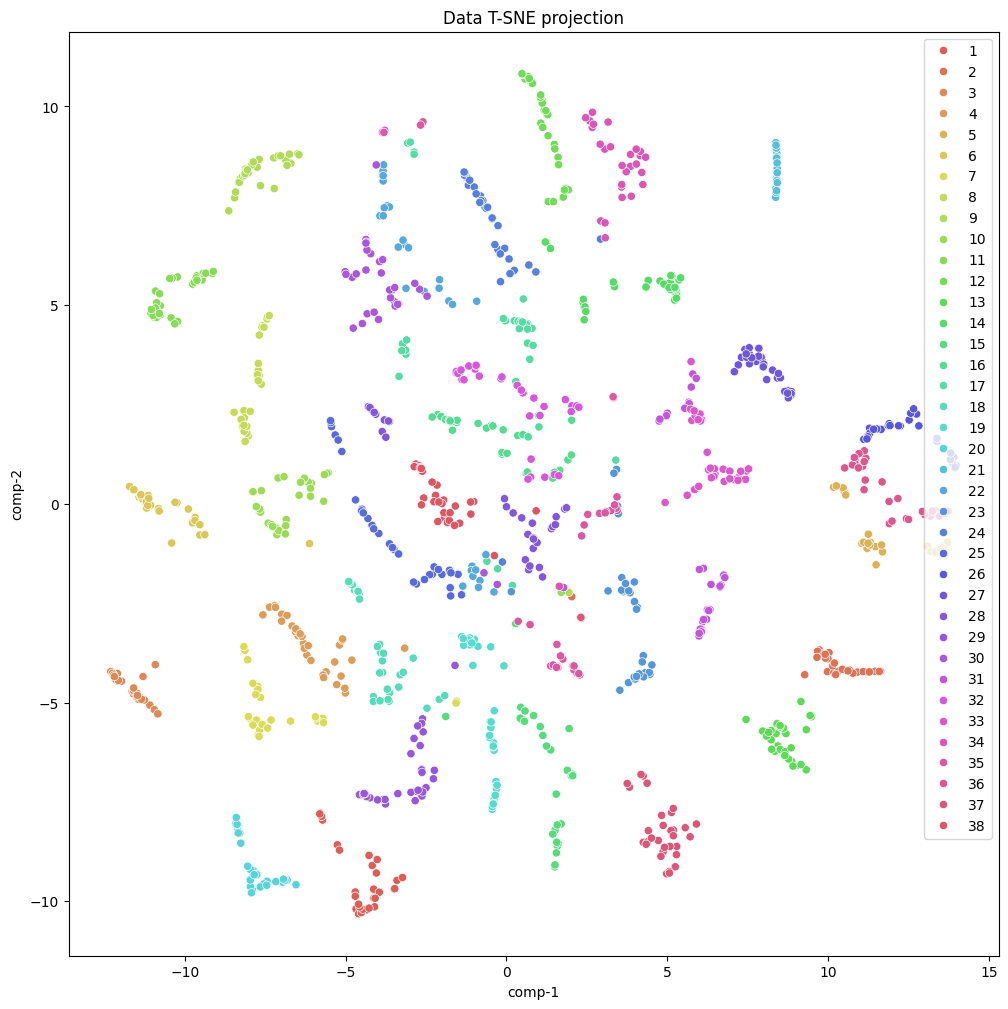

In [9]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

# Calculate tsne
tsne = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300)
z = tsne.fit_transform(Y_train.transpose())

# Prepare data for tsne
df = pd.DataFrame()
df["y"] = label_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

# Plot tsne
fig = plt.figure(figsize = (12, 12))
sns.scatterplot(
    x="comp-1", y="comp-2", hue=df.y.tolist(),
    palette=sns.color_palette("hls", len(set(label_train))),
    data=df
).set(title="Data T-SNE projection")

# Sparse Representation-based Classification (SRC)



## Compute dictionary as the straightforward concatenation of features vector from images

In [10]:
# Sparsity regularizer in the underlying lasso minimization problem
src = SRC.SRC(lamb=0.01)
src.fit(Y_train, label_train)

# Print info
print(f'Num Classes: {src.num_classes}')
print(f'Feature vector dimension: {src.D.shape[0]}')
print(f'Atoms in dictionary: {src.D.shape[1]}')

Num Classes: 38
Feature vector dimension: 512
Atoms in dictionary: 1216


## Image Classification using SRC on test data

In [11]:
# Predict with SRC
start = time.time()
pred = src.predict(Y_test, iterations=100, mean_spars=True)
end = time.time()

# Print results
print(f'Elapse time for prediction(s): {end - start}')
acc = np.sum(pred == label_test) / float(len(label_test))
print('Accuracy = {:.2f} %'.format(100 * acc))

Mean sparsity: 136.74540901502505 out of 1216
Std sparsity: 28.223164891961538


Elapse time for prediction(s): 27.273683071136475
Accuracy = 98.58 %


In [12]:
# Class names from prediction
if le:
  class_id = le.inverse_transform(np.asarray(label_test)-1)
  class_pred = le.inverse_transform(pred-1)
  print(f'Actual ids for the first five test samples: {class_id[0:5]}')
  print(f'Id predictions for the first five test samples: {class_pred[0:5]}')

Actual ids for the first five test samples: ['yaleB01' 'yaleB01' 'yaleB01' 'yaleB01' 'yaleB01']
Id predictions for the first five test samples: ['yaleB01' 'yaleB01' 'yaleB01' 'yaleB01' 'yaleB01']


In [13]:
# Prediction over a specific image
im_path = 'CroppedYale/yaleB04/yaleB04_P00A+000E+45.pgm'

# Load image
im = Image.open(im_path).convert("RGB")

# Apply preprocessing
im = feat_desc['preprocess'](im).unsqueeze(0).to(device)

# Compute feature vector from image
with torch.no_grad():
  image_features = feat_desc['model'](im).float()
  
# Apply post-processing
if feat_desc['type'] == 'clip':
  image_features /= image_features.norm(dim=-1, keepdim=True)
elif feat_desc['type'] == 'random':
  image_features = image_features.squeeze(0)
image_features = image_features.cpu().detach().numpy().transpose()

# Estimate label from folder name
full_path = os.path.dirname(im_path)
label = os.path.normpath(full_path).split(os.path.sep)[-1]
print(f'Actual id: {label}')

# Predict with SRC
pred_one = src.predict(image_features, iterations=100)
print(f'Predicted id: {le.inverse_transform(pred_one-1)}')

Actual id: yaleB04


Predicted id: ['yaleB04']


# Dictionary learning with structured incoherence (DLSI)

## Learn a dictionary from the training features vector obtained from images

In [14]:
# DLSI Parameters
k = 16        # k: number of atoms per class in the dictionary
lambd = 1e-6  # lambda: Sparsity regularizer in the underlying lasso minimization problem.

# Train (fit) DLSI
dlsi = DLSI.DLSI(k=k, lambd=lambd, eta=1e-3)
start = time.time()
dlsi.fit(Y_train, label_train, iterations=100, verbose=True)
end = time.time()

# Print info
print(f'Elapse time for dictionary learning(s): {end - start}')
print(f'Num Classes: {dlsi.num_classes}')
print(f'Feature vector dimension: {src.D.shape[0]}')
print(f'Atoms in dictionary: {dlsi.D.shape[1]}')

Initializing ... 


initial loss = 1043.7719


iter 	   1/100 	 loss 	 215.8077


iter 	  10/100 	 loss 	 38.1178


iter 	  20/100 	 loss 	 33.5625


iter 	  30/100 	 loss 	 31.9373


iter 	  40/100 	 loss 	 31.2501


iter 	  50/100 	 loss 	 30.9577


iter 	  60/100 	 loss 	 30.8100


iter 	  70/100 	 loss 	 30.7370


iter 	  80/100 	 loss 	 30.6947


iter 	  90/100 	 loss 	 30.6692


iter 	 100/100 	 loss 	 30.6522
Elapse time for dictionary learning(s): 4351.782673120499
Num Classes: 38
Feature vector dimension: 512
Atoms in dictionary: 608


## Image Classification using DLSI on test data

In [15]:
# Predict with DLSI
start = time.time()
pred = dlsi.predict(Y_test, iterations=100, mean_spars=True)
end = time.time()

# Print results
print(f'Elapse time for prediction(s): {end - start}')
acc = np.sum(pred == label_test) / float(len(label_test))
print('Accuracy = {:.2f} %'.format(100 * acc))

Mean sparsity: 5.484625182204063 out of 608
Std sparsity: 1.4277073837660608
Elapse time for prediction(s): 1.8393454551696777
Accuracy = 98.25 %


In [16]:
# Class names from prediction
if le:
  class_id = le.inverse_transform(np.asarray(label_test)-1)
  class_pred = le.inverse_transform(pred-1)
  print(f'Actual ids for the first five test samples: {class_id[0:5]}')
  print(f'Id predictions for the first five test samples: {class_pred[0:5]}')

Actual ids for the first five test samples: ['yaleB01' 'yaleB01' 'yaleB01' 'yaleB01' 'yaleB01']
Id predictions for the first five test samples: ['yaleB01' 'yaleB01' 'yaleB01' 'yaleB01' 'yaleB01']


In [17]:
# Prediction over a specific image
im_path = 'CroppedYale/yaleB04/yaleB04_P00A+000E+45.pgm'

# Computes feature vector (RFF) from image
im = Image.open(im_path).convert("RGB") # Read image
im = feat_desc['preprocess'](im).unsqueeze(0).to(device)
with torch.no_grad():
  image_features = feat_desc['model'](im).float()
if feat_desc['type'] == 'clip':
  image_features /= image_features.norm(dim=-1, keepdim=True)
elif feat_desc['type'] == 'random':
  image_features = image_features.squeeze(0)
image_features = image_features.cpu().detach().numpy().transpose()

# Estimate label from folder name
full_path = os.path.dirname(im_path)
label = os.path.normpath(full_path).split(os.path.sep)[-1]
print(f'Actual id: {label}')

# Predict with DLSI
pred_one = dlsi.predict(image_features, iterations=100)
print(f'Predicted id: {le.inverse_transform(pred_one-1)}')

Actual id: yaleB04
Predicted id: ['yaleB04']
